### Car Sales Price Prediction

As a vehicle salesperson, you would like to create a model that can estimate the overall amount that consumers would spend given some characteristics about the customer


Attributes
- customer name
- customer email 
- country
- gender
- age
- annual salary
- credit card debt
- net worth

Source:
[Kaggle](https://www.kaggle.com/datasets/yashpaloswal/ann-car-sales-price-prediction?resource=download)

In [80]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mutual_info_score, make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import time

In [2]:
file_path = r'../data/car_purchasing.csv'

In [3]:
# read the input file
df = pd.read_csv(file_path, sep=",", encoding="latin1")

In [4]:
# number of records
df.shape

(500, 9)

In [5]:
# top 5 records
df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [6]:
# proportion missing
df.isnull().mean()

customer name          0.0
customer e-mail        0.0
country                0.0
gender                 0.0
age                    0.0
annual Salary          0.0
credit card debt       0.0
net worth              0.0
car purchase amount    0.0
dtype: float64

In [7]:
# dtypes
df.dtypes

customer name           object
customer e-mail         object
country                 object
gender                   int64
age                    float64
annual Salary          float64
credit card debt       float64
net worth              float64
car purchase amount    float64
dtype: object

In [8]:
df["gender"].value_counts(normalize=True)

1    0.506
0    0.494
Name: gender, dtype: float64

In [9]:
# summary of numeric fields
df.describe()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.241674,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.978862,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,40.949969,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.049901,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,51.612263,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


In [10]:
# unique count of country
df["country"].nunique()

211

In [11]:
df["country"].value_counts()

Israel                 6
Mauritania             6
Bolivia                6
Greenland              5
Saint Barthélemy       5
                      ..
El Salvador            1
Denmark                1
Oman                   1
Trinidad and Tobago    1
marlal                 1
Name: country, Length: 211, dtype: int64

In [12]:
# duplicates?
df.duplicated().sum()

0

### Conclusion

1) The dataset is very small - 500 users with 9 attributes including the purchase amount.
2) There are no duplicates or missing values in the dataset.
3) Users are spread across 211 countries
4) The gender divide is almost equal.
5) Age range of the buyers vary from 20 - 70 with 75% of the users being under 51 years.
6) Annual salary varies from 20K - 100K.
7) Credit card debt ranges from 100 - 20K.
8) The Networth of individuals ranges from 20K - 1M.
9) The car purchase amoutn ranges from 9K - 80K.


In [13]:
def clean_names():
    """Rename some of the columns in the DataFrame"""
    col_rename = {
        "customer name": "customer_name",
        "customer e-mail": "email",
        "annual Salary": "annual_salary",
        "credit card debt": "credit_card_debt",
        "net worth": "net_worth",
        "car purchase amount": "car_purchase_amount"
    }
    df.rename(columns=col_rename, inplace=True)

In [14]:
clean_names()

In [15]:
df.columns

Index(['customer_name', 'email', 'country', 'gender', 'age', 'annual_salary',
       'credit_card_debt', 'net_worth', 'car_purchase_amount'],
      dtype='object')

### Plot some charts

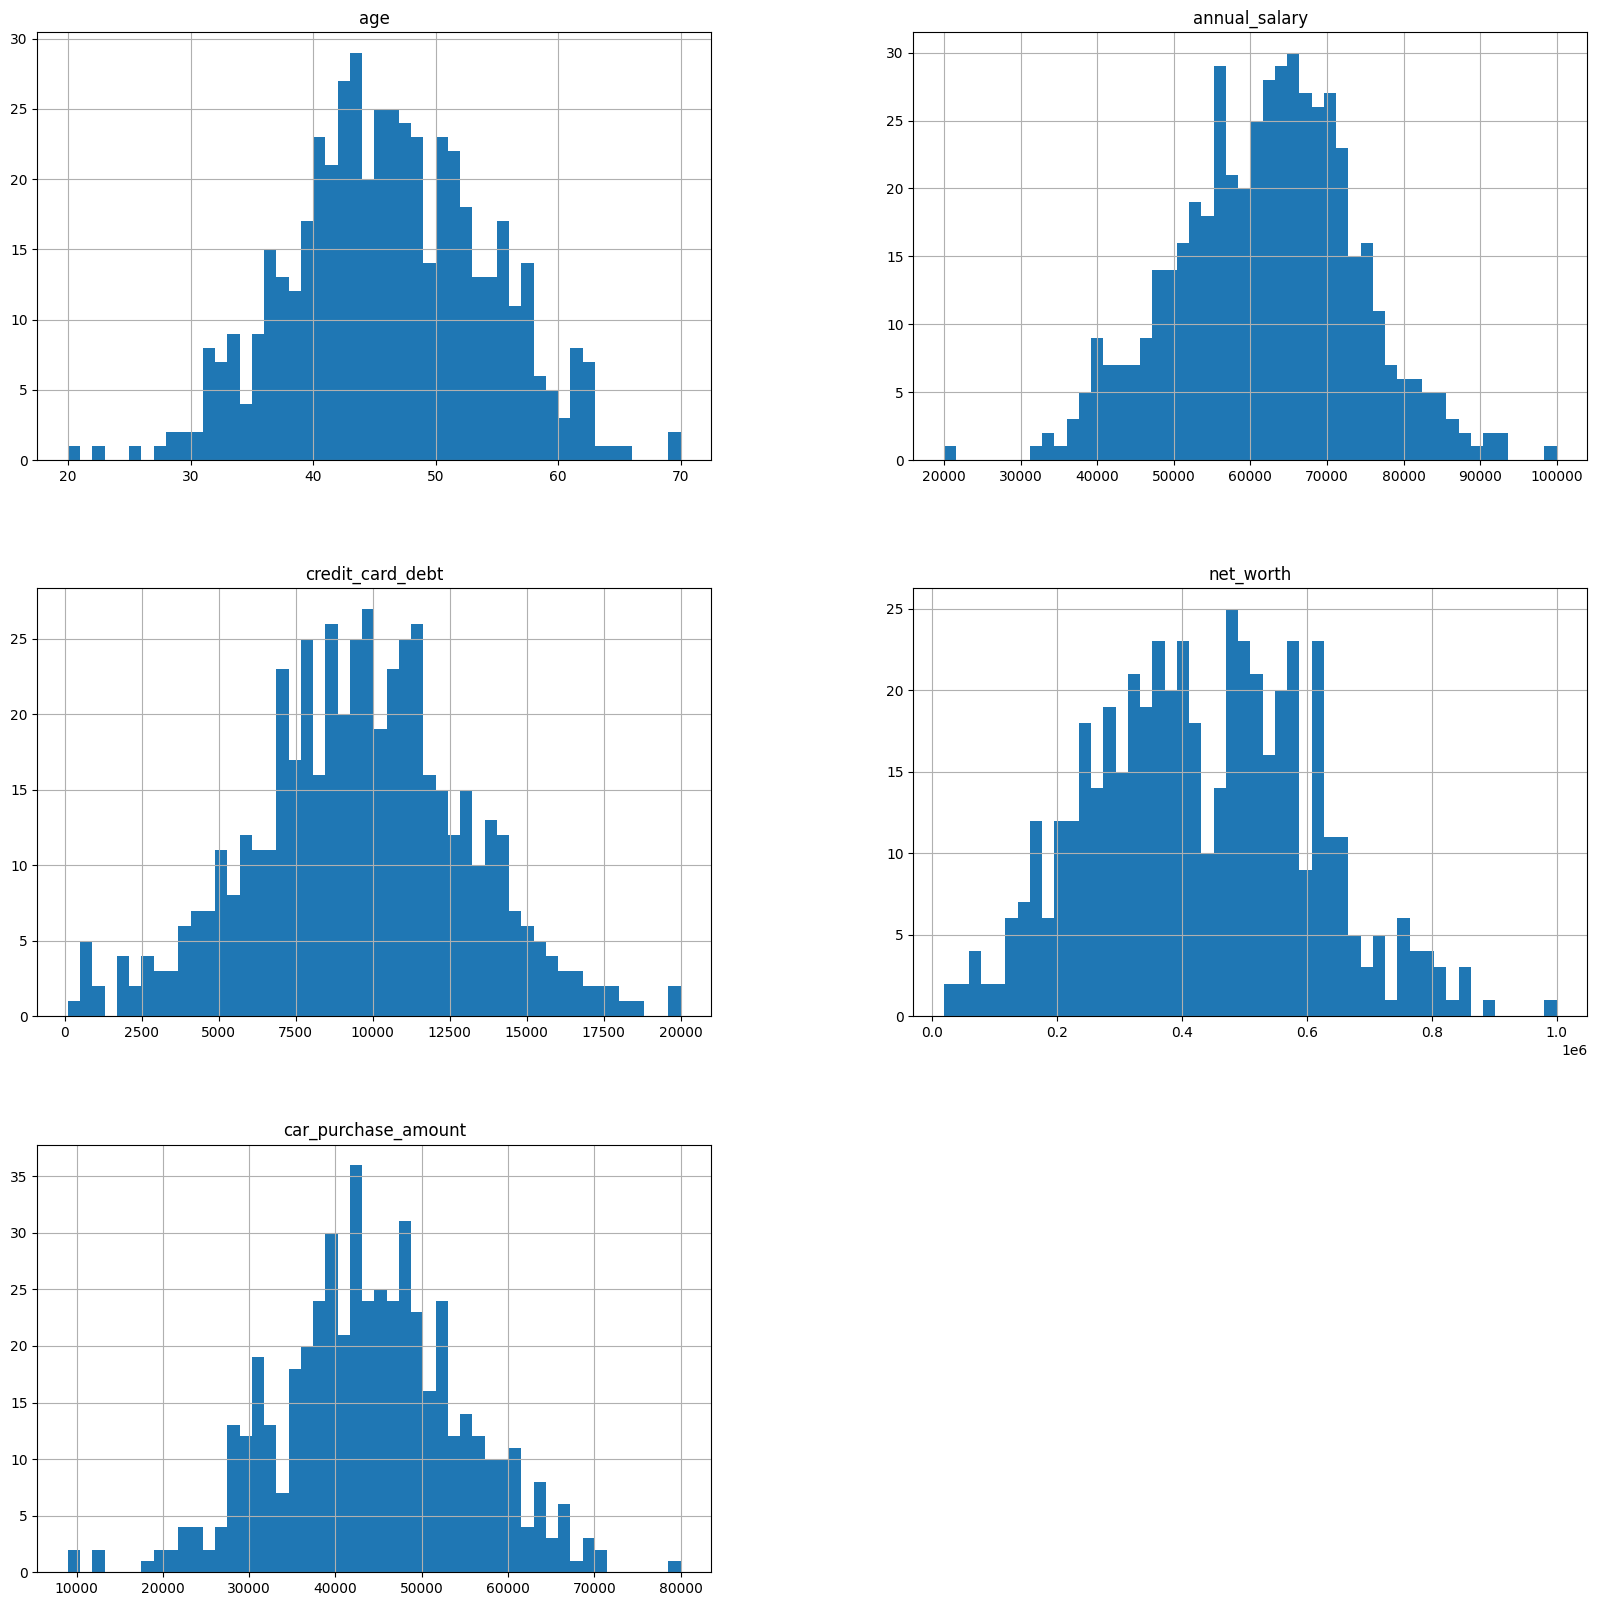

In [16]:
fields = ['age', 'annual_salary', 'credit_card_debt', 'net_worth', 'car_purchase_amount']
g = df[fields].hist(bins=50, figsize=(20, 20))
plt.show()

**Observeration**

Except for a few outliers, the distributions of the numerical variables appears to be normally distributed

In [17]:
# correlation
df[fields].corr()

,age,annual_salary,credit_card_debt,net_worth,car_purchase_amount
age,1.000000,0.000130,0.034721,0.020356,0.632865
annual_salary,0.000130,1.000000,0.049599,0.014767,0.617862
credit_card_debt,0.034721,0.049599,1.000000,-0.049378,0.028882
net_worth,0.020356,0.014767,-0.049378,1.000000,0.488580
car_purchase_amount,0.632865,0.617862,0.028882,0.488580,1.000000


**Observation**

Only age, annual_salary and to some extent net_worth are positively correlated with car_purchase_amount

In [18]:
is_above_avg = np.where(df["car_purchase_amount"] >= df["car_purchase_amount"].mean(), 1, 0)

In [19]:
def calculate_mi(col):
    return mutual_info_score(df[col], is_above_avg)

calculate_mi("country")

0.29184566034448267

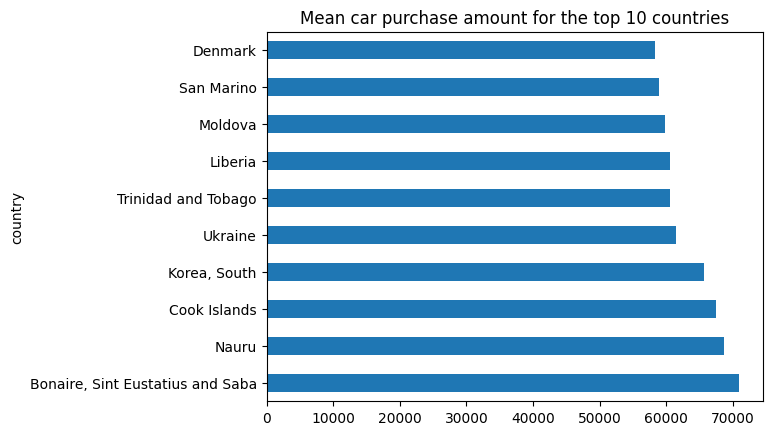

In [20]:
df.groupby("country")["car_purchase_amount"].mean().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Mean car purchase amount for the top 10 countries')
plt.show()

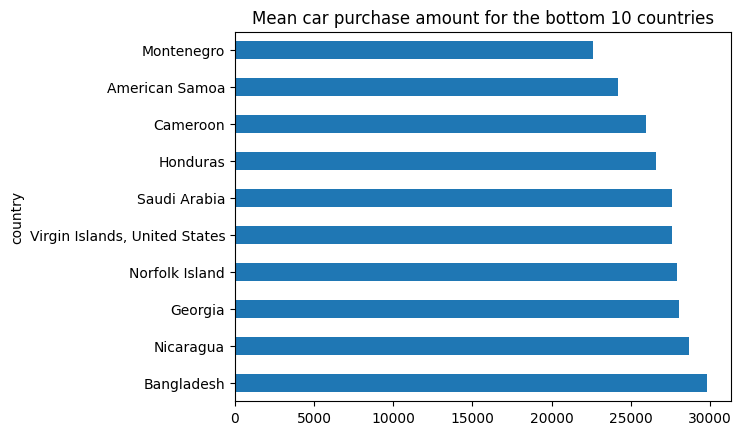

In [21]:
df.groupby("country")["car_purchase_amount"].mean().sort_values(ascending=False)[-10:].plot(kind='barh')
plt.title('Mean car purchase amount for the bottom 10 countries')
plt.show()

In [22]:
def plot_scatter(numeric_fields, 
                 country="Israel",
                 y="car_purchase_amount",
                 alpha=0.04,
                 figsize=(7, 5)
                ):
    """Plot Scatter plot for numeric field versus car purchase amount filtered on Country"""
    mask = df["country"] == country
    for field in numeric_fields:
        df[mask].plot(kind='scatter', x=field, y='car_purchase_amount', figsize=figsize, 
                                   title=f"Scatter plot of {field} versus car purchase amount in {country}")
        plt.show()

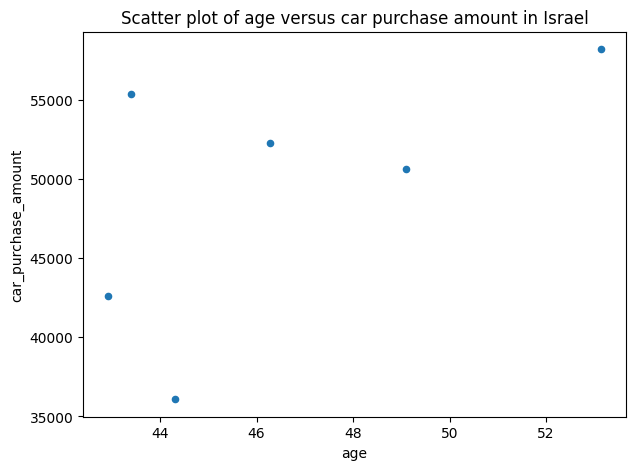

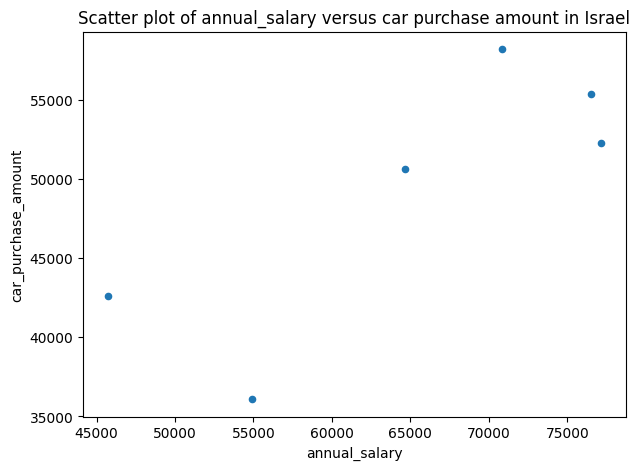

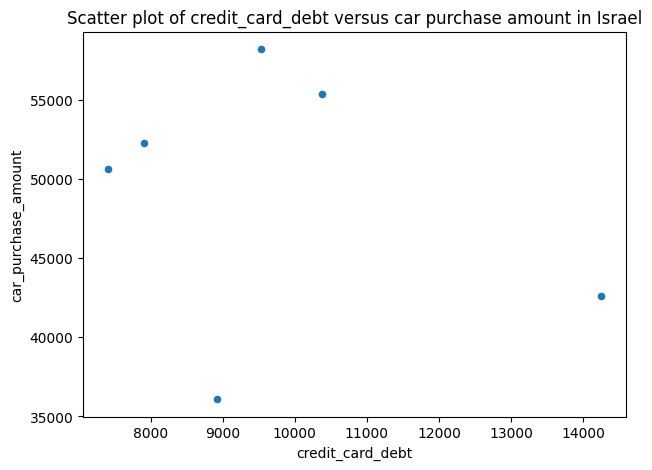

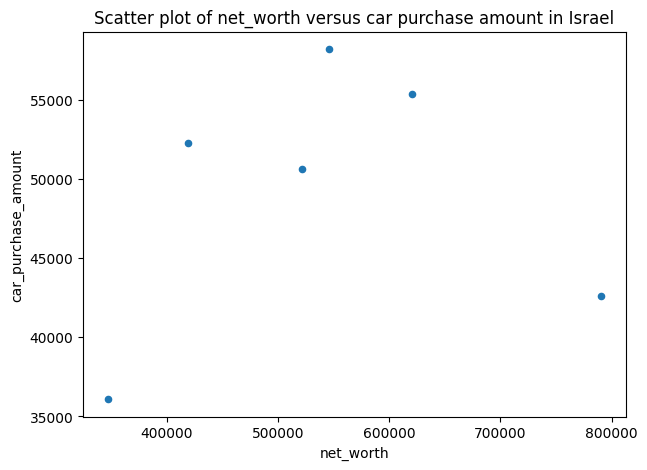

In [23]:
fields = ['age', 'annual_salary', 'credit_card_debt', 'net_worth']
plot_scatter(fields)

**Observation**

There aren't enough data points by the Country dimension to make sense of the scatter plot for any given country

### Data preparation

In [24]:
dv = DictVectorizer(sparse=False)
oe = OrdinalEncoder(encoded_missing_value=-1)

In [25]:
def split_dataset(df, 
                  size1=0.1, 
                  size2=0.11, 
                  random_state=42
                 ):
    train_df, test_x = train_test_split(df, test_size=size1, random_state=random_state)
    train_x, val_x = train_test_split(train_df, test_size=size2, random_state=random_state)
    return train_x.reset_index(drop=True), val_x.reset_index(drop=True), test_x.reset_index(drop=True)

In [69]:
def data_prep(df, 
              split,
              is_gender=True,
              is_country=True, 
              is_train=True):
    """Prepare dataset"""
    df = split_dataset(df)[split]
    try:
        df = df.drop(["customer_name", "email"], axis=1)
    except:
        pass
    if is_gender:
        df["gender"] = df["gender"].apply(lambda x: "male" if x == 1 else "female")
    else:
        del df["gender"]
    if is_country:
        if is_train:
            oe.fit(df["country"].values.reshape(-1, 1))
        df["country"] = oe.transform(df["country"].values.reshape(-1, 1))
    else:
        del df["country"]
    dicts = df.to_dict(orient='records')
    if is_train:
        dv.fit(dicts)
    df = pd.DataFrame(dv.transform(dicts), columns=dv.get_feature_names_out())
    y = df["car_purchase_amount"]
    del df["car_purchase_amount"]
    return df, y

In [27]:
# train_x, val_x, test_x = split_dataset(df)

In [28]:
# train_x.shape, val_x.shape, test_x.shape

In [71]:
train_x, train_y = data_prep(df, 0, is_gender=False,
                             is_country=False)
val_x, val_y = data_prep(df, 1, is_gender=False,
                         is_country=False)
test_x, test_y = data_prep(df, 2, is_gender=False,
                           is_country=False)

In [72]:
train_x.shape, val_x.shape, test_x.shape

((400, 4), (50, 4), (50, 4))

In [73]:
train_x.head()

,age,annual_salary,credit_card_debt,net_worth
0,40.142348,71148.20248,7917.650970,416817.4673
1,55.156973,75571.20188,12887.548990,416540.2990
2,48.921401,68502.10943,5831.118245,515084.1891
3,59.619615,81565.95967,9072.063059,544291.9504
4,62.868861,75719.22986,10515.281350,474485.6659


In [32]:
train_y.head()

0    43724.48960
1    58840.53964
2    52474.71839
3    69669.47402
4    67092.23276
Name: car_purchase_amount, dtype: float64

In [37]:
def rmse(y_true, y_pred):
    """
    Make scorer to compute rmse
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [46]:
def build_model(model, train_X, train_y, valid_X, valid_y, 
                hyperparameters={}, 
                scoring=None, cv=3, model_str=None, cat_features=[], verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'xgboost':
        gs.best_estimator_.fit(train_X, train_y, verbose=verbose)
    elif model_str == "rf":
        gs.best_estimator_.fit(train_X, train_y)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(valid_X)
    best_rmse = rmse(valid_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [74]:
lr = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(lr, train_x, train_y, 
                                                        val_x, val_y,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse), cv=5, model_str="lr")

In [113]:
rf = RandomForestRegressor(random_state=42)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_x, train_y, 
                                                        val_x, val_y,
                                                        hyperparameters={'n_estimators': [3, 5, 7]}, 
                scoring=make_scorer(rmse), cv=5, model_str="rf")

In [115]:
xgb = XGBRegressor(learning_rate=.9, objective='reg:squarederror', random_state=42)
best_xgb_model, best_xgb_rmse, best_xgb_time = build_model(xgb, train_x, train_y, 
                                                        val_x, val_y,
                                                        hyperparameters={'n_estimators': [3, 5, 7]}, 
                scoring=make_scorer(rmse), cv=5, model_str="xgboost"
                                                          )

In [117]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_xgb_rmse],
              'train_time': [best_lr_time, best_rf_time, best_xgb_time]})

In [118]:
model_results_df

,model,best_rmse,train_time
0,LinearRegression,1.625563,0.02
1,RandomForestRegressor,2586.747082,0.16
2,XGBRegressor,3838.144939,0.16


### Model analysis

In [122]:
def test_prediction(model, test_X, test_y):
    """
    Predict RMSE on the test set
    """
    start_time = time.time()
    preds = model.predict(test_X)
    return np.round(time.time(), 2) - np.round(start_time, 2), rmse(test_y, preds)

In [123]:
models = [best_lr_model, best_rf_model, best_xgb_model]
for model in models:
    pred_time, best_rmse = test_prediction(model, test_x, test_y)
    print(f'The RMSE on the test set is {best_rmse}, and time to predict {pred_time} seconds')

The RMSE on the test set is 1.4293737207583241, and time to predict 0.0 seconds
The RMSE on the test set is 3252.327385619685, and time to predict 0.0 seconds
The RMSE on the test set is 3438.9125556620006, and time to predict 0.0 seconds


### Conclusion

Nothing beats the simplicity of Linear Regression for this small dataset. Inclusion of attributes of Country and Gender slighly increase the RMSE loss; therefore, these features were removed.